<center>Национальный исследовательский университет ИТМО<br/>Факультет информационных технологий и программирования<br/>Прикладная математика и информатика</center>

## <center>Методы оптимизации</center>
### <center>Отчёт по лабораторной работе №2</center>

<div style="text-align: right"><b>Работу выполнили:</b><br/>Салахов Камиль M33381<br/>Мухтаров Айнур M33371<br/>

<center>Санкт-Петербург<br/>2023</center>

In [1]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import time
from sklearn.datasets import make_regression

np.random.seed(+7_952_812)
# Да здравствует Санкт-Петербург

# Линейная регрессия
Линейная регрессия - это статистический метод, используемый для анализа связи между зависимой переменной (целевой переменной) и одной или несколькими независимыми переменными (предикторами или факторами). Цель линейной регрессии - построить линейную модель, которая описывает отношение между независимыми и зависимой переменными.
1. Зависимая переменная(Y) — переменная, которую мы хотим предсказать. <br/> $Y = (y_0, \dots, y_{n-1}), \quad y_i \in \mathbb R$
2. Независимые переменные(X) — это переменные которые используются для предсказаний или объяснений в зависимой переменной <br/> $X = (X_0, \dots, X_{n-1}), \quad X_i \in \mathbb R^k$
3. Мы предполагаем, что есть линейная функция $f : \mathbb R^k \to \mathbb R$, что $y_i \approx f(X_i)$. Для того чтобы найти f представим ее в виде: $f(x) = b + \sum_{i=0}^{k-1} w_ix_i$. Также построим функцию потерь $Loss(b, w) = \frac{1}{n} \sum_{i=0}^{n-1} (f(X_i) - y_i)^2$.
4. Далее градиентным спуском минимизируя функцию потерь мы найдем $b$ и $w$, а значит и $f$ 


# Стохастический градиентный спуск

1. Теперь вместо вычисления градиента на всех данных, будем делить их на батчи размером $l$. Для батча будем отдельно считаем $Loss$ и двигаемся в направление его антиградиента.
2. Пусть batch = $[(X_{i_1}, y_{i_1}), \dots ,(X_{i_{l-1}}, y_{i_{l-1}})]$, тогда $Loss(b, w) = \frac{1}{l} \sum_{i=0}^{l-1} (f(batch_i.X) - batch_i.y)^2$
3. $\nabla Loss(b, w)$ будет таким: <br/> $\frac{\partial Loss}{\partial b} = \frac{2}{l} \sum_{i=0}^{l-1}(f(batch_i.X) - batch_i.y)$ <br/> $\frac{\partial Loss}{\partial w_j} = \frac{2}{l} \sum_{i=0}^{l-1}(f(batch_i.X) - batch_i.y) \cdot batch_i.X_j$ <br/> Также $f(batch_i.X) = b+ \langle w, batch_i.X \rangle$
4. Если $n$ не делится нацело на $l$, тогда последний батч будет размером меньше $l$


Классы для коэффициентов и для подсчета количества операций и затрат памяти

In [2]:
class Coefficient:
    def __init__(self, dim):
        self.dim = dim
        self.w = np.zeros(dim)
        self.b = np.zeros(1)
        self.operations = 0
        self.memory = 0

    def calculate_grad(self, X, y, b, w):
        n = X.shape[0]
        m = X.shape[1]

        prev_value = b + X @ w
        y_diff = prev_value - y  # 1
        grad_b = 2.0 * np.mean(y_diff, axis=-1)  # 2
        grad_w = 2.0 * np.mean(np.transpose(X) * y_diff, axis=-1)  # 3

        self.operations += n  # 1
        self.operations += 1 + n  # 2
        self.operations += n + 3 * n * m  # 3

        self.memory += n  # 1
        self.memory += 2  # 2
        self.memory += 2 * n * m  # 3
        return grad_b, grad_w

    def get_grads(self, X, y):
        return self.calculate_grad(X, y, self.b, self.w)

    def update_stats(self, operations_multiplier, memory_multiplier):
        self.operations += operations_multiplier * self.dim
        self.memory += memory_multiplier * self.dim

    def __call__(self, b, w):
        c = Coefficient(w.shape[0])
        c.b = b
        c.w = w
        return c

    def get_normalized(self, mean, std):
        c = Coefficient(self.w.shape[0])
        c.b = (np.copy(self.b) - mean) / std
        c.w = np.copy(self.w) / std
        return c


class ExtendedCoefficient(Coefficient):
    def __init__(self, dim):
        super().__init__(dim)
        self.bv = np.zeros(1)
        self.wv = np.zeros(dim)
        self.bs = np.zeros(1)
        self.ws = np.zeros(dim)

    def get_grads(self, X, y, nesterov_factor=None):
        if nesterov_factor is None:
            return super().get_grads(X, y)
        new_b = self.b - nesterov_factor * self.bv
        new_w = self.w - nesterov_factor * self.wv
        self.operations += 4 * self.dim
        self.memory += 2 * self.dim
        return super().calculate_grad(X, y, new_b, new_w)


class AdamCoefficient(ExtendedCoefficient):
    def __init__(self, dim):
        super().__init__(dim)
        self.b1p = 1
        self.b2p = 1

Реализация линейной регрессии. Тут пришлось нормировать $X$, так как иначе не получалось контролировать градиентный спуск и float64 переполнялся

In [3]:
EPS = 1e-6


class LinearRegression:
    def __init__(self, X, y, method, coef_type="extended"):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        self.X_was = X
        self.X = (X - self.mean) / self.std
        self.y = y
        self.n = X.shape[0]
        self.dim = X.shape[1]
        self.method = method
        if coef_type == 'usual':
            self.coefficient = Coefficient(self.dim)
        elif coef_type == 'adam':
            self.coefficient = AdamCoefficient(self.dim)
        else:
            self.coefficient = ExtendedCoefficient(self.dim)
        self.way = [self.inverted_point()]

    def get_batches(self, indexes, batch_size):
        batches = (self.n + batch_size - 1) // batch_size
        for i in range(batches):
            yield self.X[indexes[batch_size * i: batch_size * (i + 1)], :], \
                self.y[indexes[batch_size * i: batch_size * (i + 1)]]

    def get_loss(self):
        return np.mean((self.coefficient.b + self.X @ self.coefficient.w - self.y) ** 2)

    def inverted_point(self):
        b = self.coefficient.b.copy()
        w = self.coefficient.w.copy()
        b = (b + self.mean) * self.std
        w = w * self.std
        return np.append(w, b)

    def start_gradient_descent(self, batch_size=5, lr=0.1, epochs=10000, learning_rate_scheduler=None):
        shuffled_indexes = np.arange(self.n)
        losses = []
        for epoch in range(epochs):
            np.random.shuffle(shuffled_indexes)
            max_norm = 0
            for batch_X, batch_y in self.get_batches(shuffled_indexes, batch_size):
                grad = self.method(self.coefficient, batch_X, batch_y, lr)
                max_norm = max(max_norm, np.linalg.norm(grad))
            losses.append(self.get_loss())
            self.way.append(self.inverted_point())
            if max_norm < EPS:
                return epoch
            if learning_rate_scheduler is not None:
                lr = learning_rate_scheduler(lr, epoch)
        return epochs

    def get_normalized_coefficient(self):
        return self.coefficient.get_normalized(self.mean, self.std)

In [4]:
def stochastic(coefficient: Coefficient, X, y, lr):
    n = X.shape[0]
    grad_b, grad_w = coefficient.get_grads(X, y)
    coefficient.b -= lr * grad_b  # 1
    coefficient.w -= lr * grad_w  # 2
    coefficient.operations += 1  # 1
    coefficient.operations += n  # 2
    return np.append(grad_w, grad_b)

Функция создает точки в заданном пространстве

In [5]:
def generate_X_y(dim=5, points=1000):
    return make_regression(n_samples=points, n_features=dim)

In [6]:
def start_test_size_regression(method, coef_type="extended", points=100, dim=5, lr=0.01, epochs=10000, scheduler=None):
    X, y = generate_X_y(dim=dim, points=points)

    iterations_for_batch = []
    memory = []
    operations = []
    times = []
    for size in tqdm.tqdm(range(1, points + 1)):
        reg = LinearRegression(X, y, method, coef_type)
        start = time.time()
        iterations = reg.start_gradient_descent(batch_size=size, lr=lr, epochs=epochs,
                                                learning_rate_scheduler=scheduler)
        diff = time.time() - start
        times.append(diff)
        coefficient = reg.coefficient
        memory.append(coefficient.memory)
        operations.append(coefficient.operations)
        iterations_for_batch.append(iterations)
    return iterations_for_batch, operations, memory, times

In [7]:
def plot_data_with_batch_sizes(iterations):
    st_xs = [i for i in range(1, len(iterations) + 1)]
    plt.xlabel("batsh size")
    plt.ylabel("epochs")
    plt.plot(st_xs, iterations)


def test_batch_sizes():
    test_sizes_points = 100
    iterations = \
        start_test_size_regression(stochastic, coef_type='usual', points=test_sizes_points, lr=0.05, epochs=10000)[0]
    plot_data_with_batch_sizes(iterations)

100%|██████████| 100/100 [00:01<00:00, 81.30it/s]


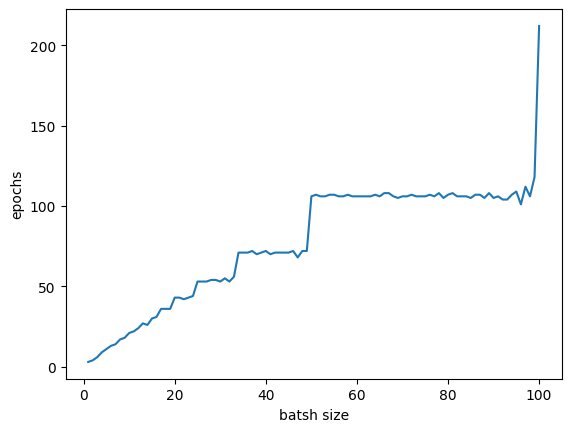

In [8]:
test_batch_sizes()

1. Вообще, классический SGD не очень хороший метод, ведь на каждом шаге он рассматривает только одну координату. Поэтому при очень маленьких батчах должно быть много итераций, так изменение коэффициентов не предсказуемо ведь зависит от малого количества переменных.
2. График скачет при таких размерах одного батча, когда на последней итерации эпохи остается ровно один элемент. Как раз из-за первого пункта у нас появляются скачки вверх
3. Сразу же после скачка итерации уменьшаются, так как размер последнего батча увеличивается
4. Число шагов градиентного спуска не зависит от размера батча, поэтому число итераций ведет себя как  $\left\lceil \frac{n}{\left\lceil\frac{n}{batchSize}\right\rceil} \right\rceil$. 

# Исследование экспоненциальной функции изменения шага (learning rate scheduling). 
При постоянном learning_rate градиентный спуск возле минимума делает большие шаги. Поэтому будем уменьшать learning_rate на каждом шаге изменяя текущий learning_rate

# Функции изменения шага
## 1. Экспоненциальная 
Текущий learning_rate домнажается на $e^{-dn}$, где $d$ - параметр затухания, $n$ это номер эпохи.
## 2. Ступенчатая
Текущий learning_rate раз в $k$ шагов домножается на $\gamma$, где $0<\gamma<1$

In [9]:
class Scheduler:
    def __init__(self, get_next_lr):
        self.get_next_lr = get_next_lr

    def __call__(self, lr, epoch):
        return self.get_next_lr(lr, epoch)

## Проверим на таких же данных как в первом задании

In [10]:
def test_scheduler(scheduler):
    iterations = start_test_size_regression(stochastic, 'usual', points=100, lr=0.15, epochs=10000,
                                            scheduler=scheduler)[0]
    plot_data_with_batch_sizes(iterations)

In [11]:
def step_function(lr, epoch, gamma=0.9):
    if epoch != 0 and epoch % 20 == 0:
        return lr * gamma
    return lr


exp_scheduler = Scheduler(lambda lr, epoch: lr * np.exp(-0.0001 * epoch))
step_scheduler = Scheduler(step_function)

График с экспоненциальной функцией

100%|██████████| 100/100 [00:00<00:00, 147.13it/s]


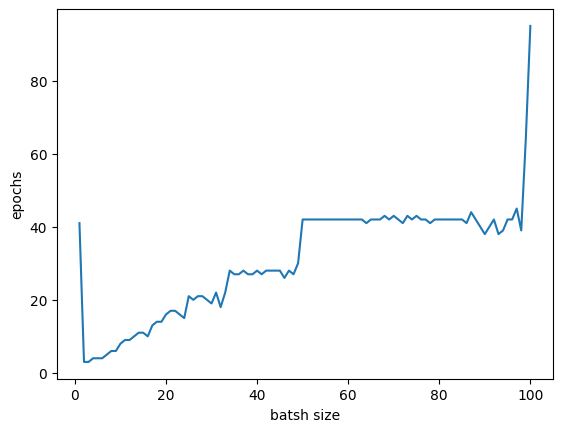

In [12]:
test_scheduler(exp_scheduler)

График со ступенчатой функцией

100%|██████████| 100/100 [00:00<00:00, 179.08it/s]


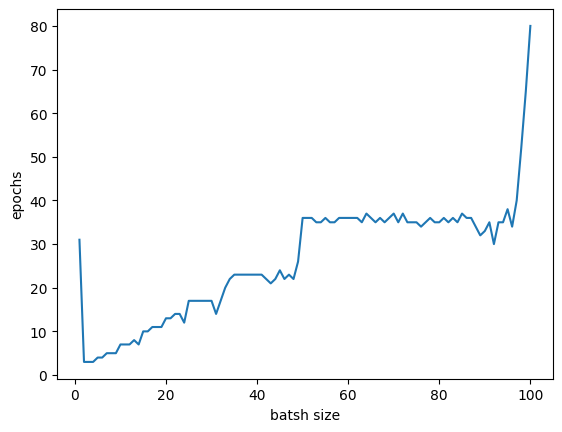

In [13]:
test_scheduler(step_scheduler)

Запустив exponential и step scheduler можно заметить, что количество итераций спуска уменьшилось.
Также на графиках как раз видно, что при маленьких батчах SGD может плохо работать 

# Исследование модификаций градиентного спуска

# Momentum
В данном методе мы усредняем/сглаживаем градиент. Также Momentum можно интерпретировать так: рассмотрим градиентный спуск как спуск шарика по поверхности и добавим этому шарику инерцию/скорость. $v_i$ даст нам то, что если шарик двигался в одну сторону, то желательно дальше идти в ее направлении. 
$v_{i+1} = \gamma v_i + (1- \gamma)g_i$ <br/>
$w_{i+1} = w_i - \alpha v_{i+1}$

In [14]:
def Momentum(coefficient: ExtendedCoefficient, X, y, lr=0.1, gamma=0.8):
    grad_b, grad_w = coefficient.get_grads(X, y)

    coefficient.bv = gamma * coefficient.bv + (1 - gamma) * grad_b  # 1
    coefficient.wv = gamma * coefficient.wv + (1 - gamma) * grad_w  # 2

    coefficient.b -= lr * coefficient.bv
    coefficient.w -= lr * coefficient.wv
    coefficient.update_stats(6, 4)
    return np.append(grad_w, grad_b)

# Nesterov
Этот метод является улучшенной версией Momentum SGD. У Нестерова появилась идея заглядывать вперед по вектору обновления. Таким образом, мы считаем производные не в самой точке, а в точке которая находится в стороне минимума.
$v_i = \gamma v_i + (1 - \gamma) g(w_i - \alpha\gamma \, v_i)$ <br/>
$w_{i+1} = w_i - \alpha v_{i+1}$


In [15]:
def Nesterov(coefficient: ExtendedCoefficient, X, y, lr=0.13, gamma=0.8):
    grad_new_b, grad_new_w = coefficient.get_grads(X, y, nesterov_factor=lr * gamma)

    coefficient.bv = gamma * coefficient.bv + (1 - gamma) * grad_new_b  # 1
    coefficient.wv = gamma * coefficient.wv + (1 - gamma) * grad_new_w  # 2

    coefficient.b -= lr * coefficient.bv
    coefficient.w -= lr * coefficient.wv
    coefficient.update_stats(6, 4)
    return np.append(grad_new_w, grad_new_b)

# AdaGrad (Adaptive gradient)
Идея этого метода такова: для тех $x_i$ которые часто обновляются мы хотим уменьшить шаг, а для тех кто редко наоборот увеличить. $G_i$ накапливает изменения для каждой координаты и в общем виде формула будет такова:
$1) \: G_{i+1} = G_i + g_i*g_i^T$ <br>
$2) \: w_{i+1} = w_i - \frac{\alpha g_i}{\sqrt{G_{i+1} + \epsilon}}$ <br/>
В формула 2) деление для каждой координаты происходит отдельно, т.е если $d = \frac{a}{b}$, то $d_j=\frac{a_j}{b_j}$  
Также делении добавляем $\epsilon$, чтобы не появилось деления на 0



In [16]:
def AdaGrad(coefficient: ExtendedCoefficient, X, y, lr=100, ADA_GRAD_EPS=1e-7):
    grad_b, grad_w = coefficient.get_grads(X, y)

    coefficient.bs += grad_b ** 2
    coefficient.ws += grad_w ** 2
    coefficient.update_stats(2, 2)

    coefficient.b -= lr * grad_b / np.sqrt(coefficient.bs + ADA_GRAD_EPS)
    coefficient.w -= lr * grad_w / np.sqrt(coefficient.ws + ADA_GRAD_EPS)
    coefficient.update_stats(6, 2)

    return np.append(grad_w, grad_b)

# RMSProp (Root mean square propagation)
RMSProp - это модификация AdaGrad и ее улучшение заключается в следующем. Теперь мы будем не суммировать изменения, а хранить среднее квадратов градиента. И формула в RMSProp получается почти такая же как в AdaGrad 
$S_{i+1} = \beta S_i + (1-\beta) g_i^2$ <br/>
$w_{i+1} = w_i - \frac{\alpha g_i}{\sqrt{S_i + \epsilon}}$ <br/>


In [17]:
def RMSProp(coefficient: ExtendedCoefficient, X, y, lr=3, beta=0.999, RMS_PROP_EPS=1e-7):
    grad_b, grad_w = coefficient.get_grads(X, y)

    coefficient.bs = beta * coefficient.bs + (1 - beta) * grad_b * grad_b
    coefficient.ws = beta * coefficient.ws + (1 - beta) * grad_w * grad_w
    coefficient.update_stats(8, 2)

    coefficient.b -= lr * grad_b / np.sqrt(coefficient.bs + RMS_PROP_EPS)
    coefficient.w -= lr * grad_w / np.sqrt(coefficient.ws + RMS_PROP_EPS)
    coefficient.update_stats(6, 2)

    return np.append(grad_w, grad_b)

# Adam (Adaptive moment estimation)
Этот метод объединяет Momentum и RMSProp. <br/>
Будем хранить усреднение градиентов: $v_{i+1} = \beta_1v_i + (1-\beta_1)g_i$
Также будем хранить среднее квадратов градиентов $S_{i+1} = \beta_2S_i + (1-\beta_2)g_i^2$
В этом методе есть проблема долгого накапливания $v_i$ и $S_i$ поэтому введем новые переменные. <br/>
 $\widehat v_{i+1} = \frac{v_{i+1}}{1- \beta_1^{i+1}}$, $\widehat S_{i+1} = \frac{s_{i+1}}{1- \beta_2^{i+1}}$ <br/>
Тогда $w_{i+1} = w_i - \frac{\alpha \widehat v_{i+1}}{\sqrt{\widehat S_{i+1} + \epsilon}}$

In [18]:
def Adam(coefficient: AdamCoefficient, X, y, lr=3.5, beta1=0.9, beta2=0.999, ADAM_EPS=1e-8):
    grad_b, grad_w = coefficient.get_grads(X, y)

    coefficient.bv = beta1 * coefficient.bv + (1 - beta1) * grad_b
    coefficient.wv = beta1 * coefficient.wv + (1 - beta1) * grad_w
    coefficient.update_stats(6, 2)

    coefficient.bs = beta2 * coefficient.bs + (1 - beta2) * grad_b * grad_b
    coefficient.ws = beta2 * coefficient.ws + (1 - beta2) * grad_w * grad_w
    coefficient.update_stats(8, 2)

    coefficient.b1p *= beta1
    coefficient.b2p *= beta2
    coefficient.operations += 2

    new_bv = coefficient.bv / (1 - coefficient.b1p)
    new_wv = coefficient.wv / (1 - coefficient.b1p)
    coefficient.update_stats(1, 1)

    new_bs = coefficient.bs / (1 - coefficient.b2p)
    new_ws = coefficient.ws / (1 - coefficient.b2p)
    coefficient.update_stats(1, 1)

    coefficient.b -= lr * new_bv / np.sqrt(new_bs + ADAM_EPS)
    coefficient.w -= lr * new_wv / np.sqrt(new_ws + ADAM_EPS)
    coefficient.update_stats(6, 2)
    return np.append(grad_w, grad_b)

# Протестируем методы

In [81]:
methods = [[Momentum, 0.06, 'extended'], [Nesterov, 0.13, 'extended'], [AdaGrad, 80, 'extended'],
           [RMSProp, 1, 'extended'], [Adam, 2, 'adam']]


def test_methods():
    iterations = []
    memory = []
    operations = []
    times = []

    for method, lr, coef_type in methods:
        method_iterations, method_memory, method_operations, method_times = start_test_size_regression(method,
                                                                                                       coef_type=coef_type,
                                                                                                       lr=lr,
                                                                                                       points=500)
        iterations.append(method_iterations)
        memory.append(method_memory)
        operations.append(method_operations)
        times.append(method_times)

    return iterations, memory, operations, times

In [82]:
methods_data = test_methods()

100%|██████████| 500/500 [00:18<00:00, 26.73it/s]


In [83]:
names = ['Momentum', 'Nesterov', 'AdaGrad', 'RMSProp', 'Adam']


def plot_test_methods(methods_data, ylabel, less=False):
    plt.ylabel(ylabel)
    plt.xlabel('batch size')
    xs = np.arange(1, len(methods_data[0]) + 1)
    if less:
        xs = xs[::15]
    for data in methods_data:
        if less:
            data = data[::15]
        plt.plot(xs, data)
    plt.legend(names)


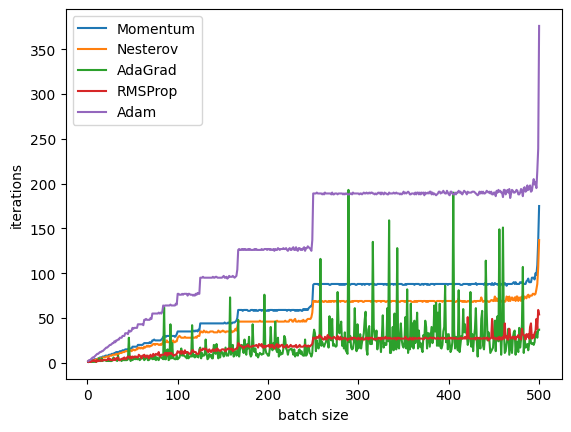

In [84]:
plot_test_methods(methods_data[0], 'iterations')

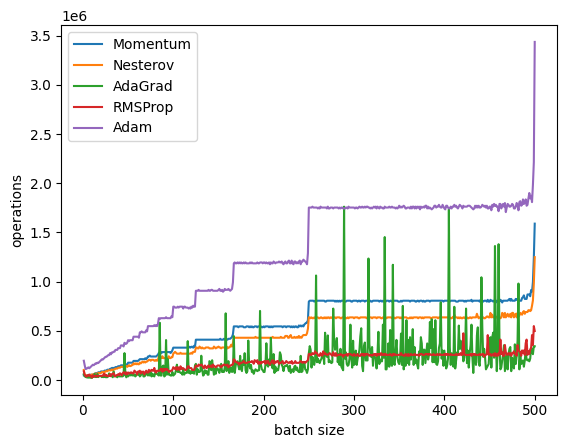

In [85]:
plot_test_methods(methods_data[1], 'operations')

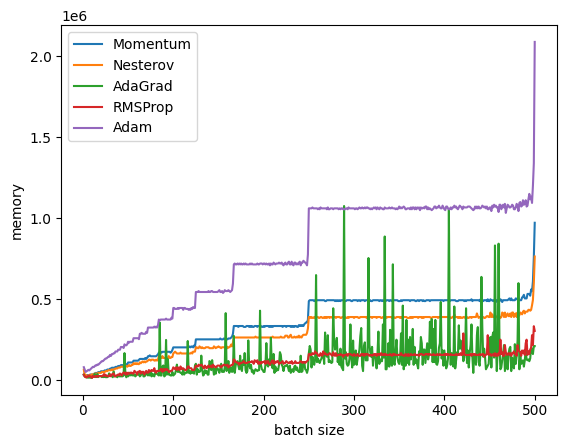

In [86]:
plot_test_methods(methods_data[2], 'memory')

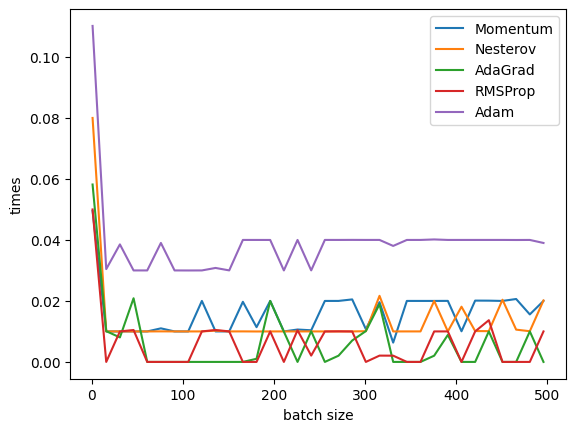

In [87]:
plot_test_methods(methods_data[3], 'times', less=True)

# Итого
По графику можно сделать топ методов: AdaGrad, RMSProp, Nesterov, Momentum, Adam.
AdaGrad и RMSProp делают большие шаги поэтому сработали лучше всех.
Хоть RMSProp является улучшенной версией AdaGrad, но сработало чуть хуже. А вот Nesterov сработал лучше, чем Momentum. 
Хоть Adam это улучшенная версия RMSProp и Momentum, но он сработал хуже всех. Похоже он плохо работает с обычной линейной регрессией. Либо нужно правильно подбирать learning rate, чтобы он хорошо работал. Но несмотря на это этот алгоритм популярен. Таким образом, перед тем как выбирать метод в SGD нужно хорошо подумать и выбрать оптимальный в зависимости от ситуации.

# Рассмотрим траектории спуска алгоритмов

In [88]:
def test_trajectory():
    n = 100
    batch_size = 5
    X = np.random.uniform(-1, 1, (n, 1))
    w = np.random.uniform(-5, 5, 1)
    b = np.random.uniform(-5, 5, 1)
    y = X @ w + b
    y += np.random.uniform(-1, 1, n)
    points = []
    for method, lr, coef_type in methods:
        reg = LinearRegression(X, y, method, coef_type=coef_type)
        reg.start_gradient_descent(batch_size=batch_size, lr=lr, epochs=15)
        points.append(reg.way)
    return X, y, points

In [89]:
def plot_trajectory(X, y, points, title):
    function = np.vectorize(lambda a, b: np.mean((X @ np.array([a]) + b - y) ** 2))
    points = np.array(points)
    levels = sorted(set(function(points[:, 0], points[:, 1])))
    plt.title(title)
    tx = np.linspace(np.min(points[:, 0]) - 0.1, np.max(points[:, 0]) + 0.1, 100)
    ty = np.linspace(np.min(points[:, 1]) - 0.1, np.max(points[:, 1]) + 0.1, 100)
    Xgrid, Ygrid = np.meshgrid(tx, ty)
    plt.plot(points[:, 0], points[:, 1])
    plt.contourf(Xgrid, Ygrid, function(Xgrid, Ygrid), levels=levels, norm='symlog')

In [92]:
X, y, points = test_trajectory()

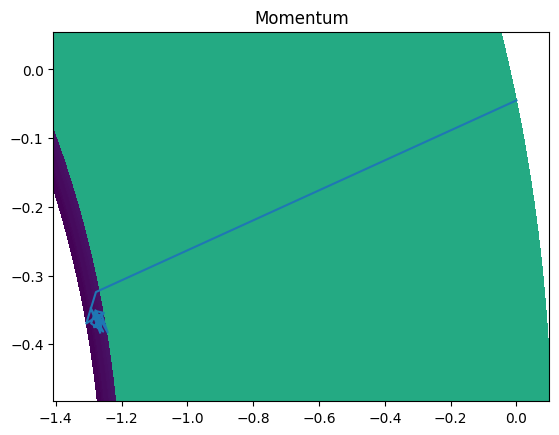

In [93]:
plot_trajectory(X, y, points[0], names[0])

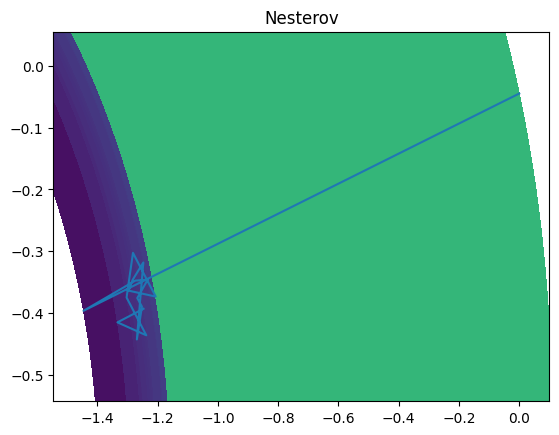

In [94]:
plot_trajectory(X, y, points[1], names[1])

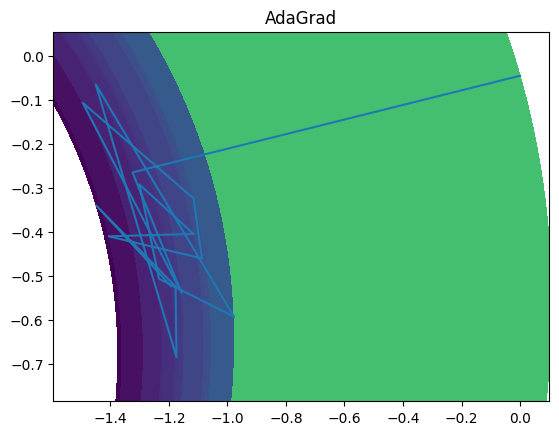

In [95]:
plot_trajectory(X, y, points[2], names[2])

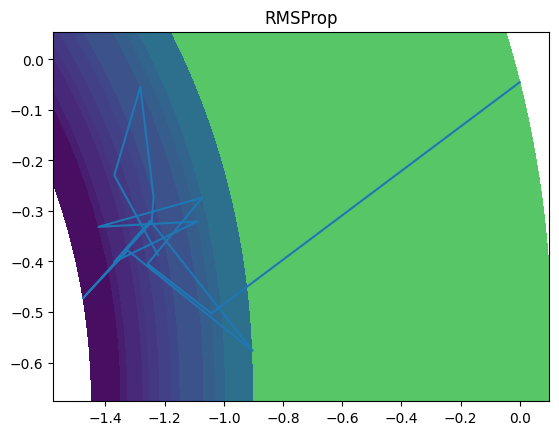

In [96]:
plot_trajectory(X, y, points[3], names[3])

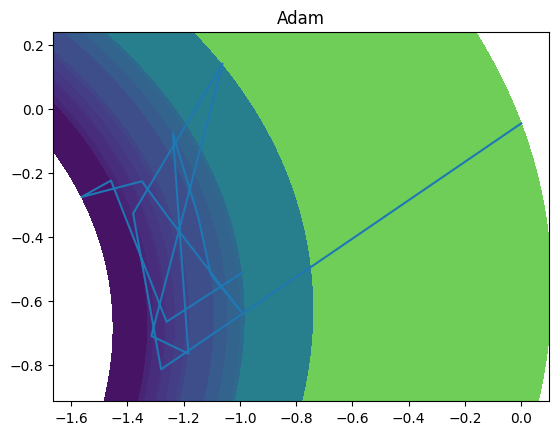

In [97]:
plot_trajectory(X, y, points[4], names[4])

Nesterov и Momentum, делают маленькие шаги, тем сам самым долго достигают минимума. AdaGrad и RMSProp и Adam проявляют себя на больших итерациях, поэтому тут не имеет особого смысла рассматривать их графики. 

# Полиномиальная регрессия

У нас также есть точки X, y, но вместо линейной функции, теперь мы хотим найти полином $p(x) = b + \sum_{i=0}^{k-1} w_i*x^{i+1}$, что $p(X_i) \approx y_i$. Нам также как до этого нужно найти такие b и $w_i$, при котором достигается минимум функции потерь. 
Функция потерь почти не изменилась: $Loss(w) = \frac{1}{n}\sum_{i=0}^{n-1} (p(X_i) - y_i)^2$
А вот производные изменились: <br/> $\frac{\partial Loss}{\partial w_j}(x) = \frac{2}{n}\sum_{i=0}^{n-1} x^j(p(x) - y_i)$ <br/>$\frac{\partial Loss}{\partial b}(x) = \frac{2}{n}\sum_{i=0}^{n-1} (p(x) - y_i)$

In [98]:
def x_transform(X, degree):
    t = X.copy()
    xs = []
    for i in range(degree):
        xs.append(t ** i)
    return np.array(xs).T


class PolynomialRegression:
    def __init__(self, X, y, degree, regularization=None):
        self.mean = np.mean(X)
        self.std = np.std(X)
        self.X_was = X
        X = (X - self.mean) / self.std
        self.X = x_transform(X, degree)
        self.n, self.m = self.X.shape
        self.w = np.zeros((self.m, 1))
        self.b = 0
        self.y = y.reshape(self.n, 1)
        self.regularization = regularization

    def get_grads(self, X, y, y_hat):
        m = X.shape[0]
        dw = (1 / m) * np.dot(X.T, (y_hat - y))
        db = (1 / m) * np.sum((y_hat - y))
        if self.regularization is not None:
            add_b, add_w = self.regularization(self.b, self.w)
            dw += add_w
            db += add_b
        return dw, db

    def start_gradient_descent(self, batch_size, epochs, lr, EPS=1e-6, lr_scheduler=None):
        indexes = np.arange(self.n)
        for epoch in range(epochs):
            np.random.shuffle(indexes)
            for i in range((self.m - 1) // batch_size + 1):
                start_i = i * batch_size
                end_i = start_i + batch_size
                xb = self.X[indexes[start_i:end_i]]
                yb = self.y[indexes[start_i:end_i]]

                y_hat = np.dot(xb, self.w) + self.b

                dw, db = self.get_grads(xb, yb, y_hat)
                grad = np.append(dw, db)
                if np.linalg.norm(grad) < EPS:
                    break
                self.w -= lr * dw
                self.b -= lr * db
                if lr_scheduler is not None:
                    lr = lr_scheduler(lr, epoch)
                # print(self.b)
        return self.w, self.b

    def loss(self):
        return np.mean((self.evaluate() - self.y) ** 2)

    def evaluate(self):
        return self.b + self.X @ self.w

Создадим 6 случайных полиномов со степенями от 1 до 6. и Приблизим каждый из них полиномом 3 степени  

In [99]:
def prepare_data():
    n = 6
    Xs = np.linspace(-10, 10, 1000)
    Ys = []
    for degree in range(1, n + 1):
        coefs = np.random.uniform(-0.05, 0.05, degree + 1)
        ys = np.polyval(coefs, Xs)
        Ys.append(ys)
    return Xs, Ys


In [100]:
Xs, Ys = prepare_data()


def test_polynoms(regularizations=[], names=[]):
    n = 6
    xs = Xs
    fig, axs = plt.subplots(2, 3, figsize=(30, 25))
    d = {}

    def draw_with_regularization(regularization=None):
        for degree in range(1, n + 1):
            ys = Ys[degree - 1]
            reg = PolynomialRegression(xs, ys, 4, regularization=regularization)
            reg.start_gradient_descent(batch_size=10, lr=0.06, epochs=3000)
            reg_ys = reg.evaluate()
            d[regularization] = reg.loss()
            row = (degree - 1) // 3
            column = (degree - 1) % 3
            axs[row, column].plot(xs, reg_ys)

    for degree in range(1, n + 1):
        ys = Ys[degree - 1]
        row = (degree - 1) // 3
        column = (degree - 1) % 3
        axs[row, column].plot(xs, ys)
    draw_with_regularization()
    for regularization in regularizations:
        draw_with_regularization(regularization)
    names = ['graphic', 'without'] + names
    for i in range(2):
        for j in range(3):
            axs[i, j].legend(names)

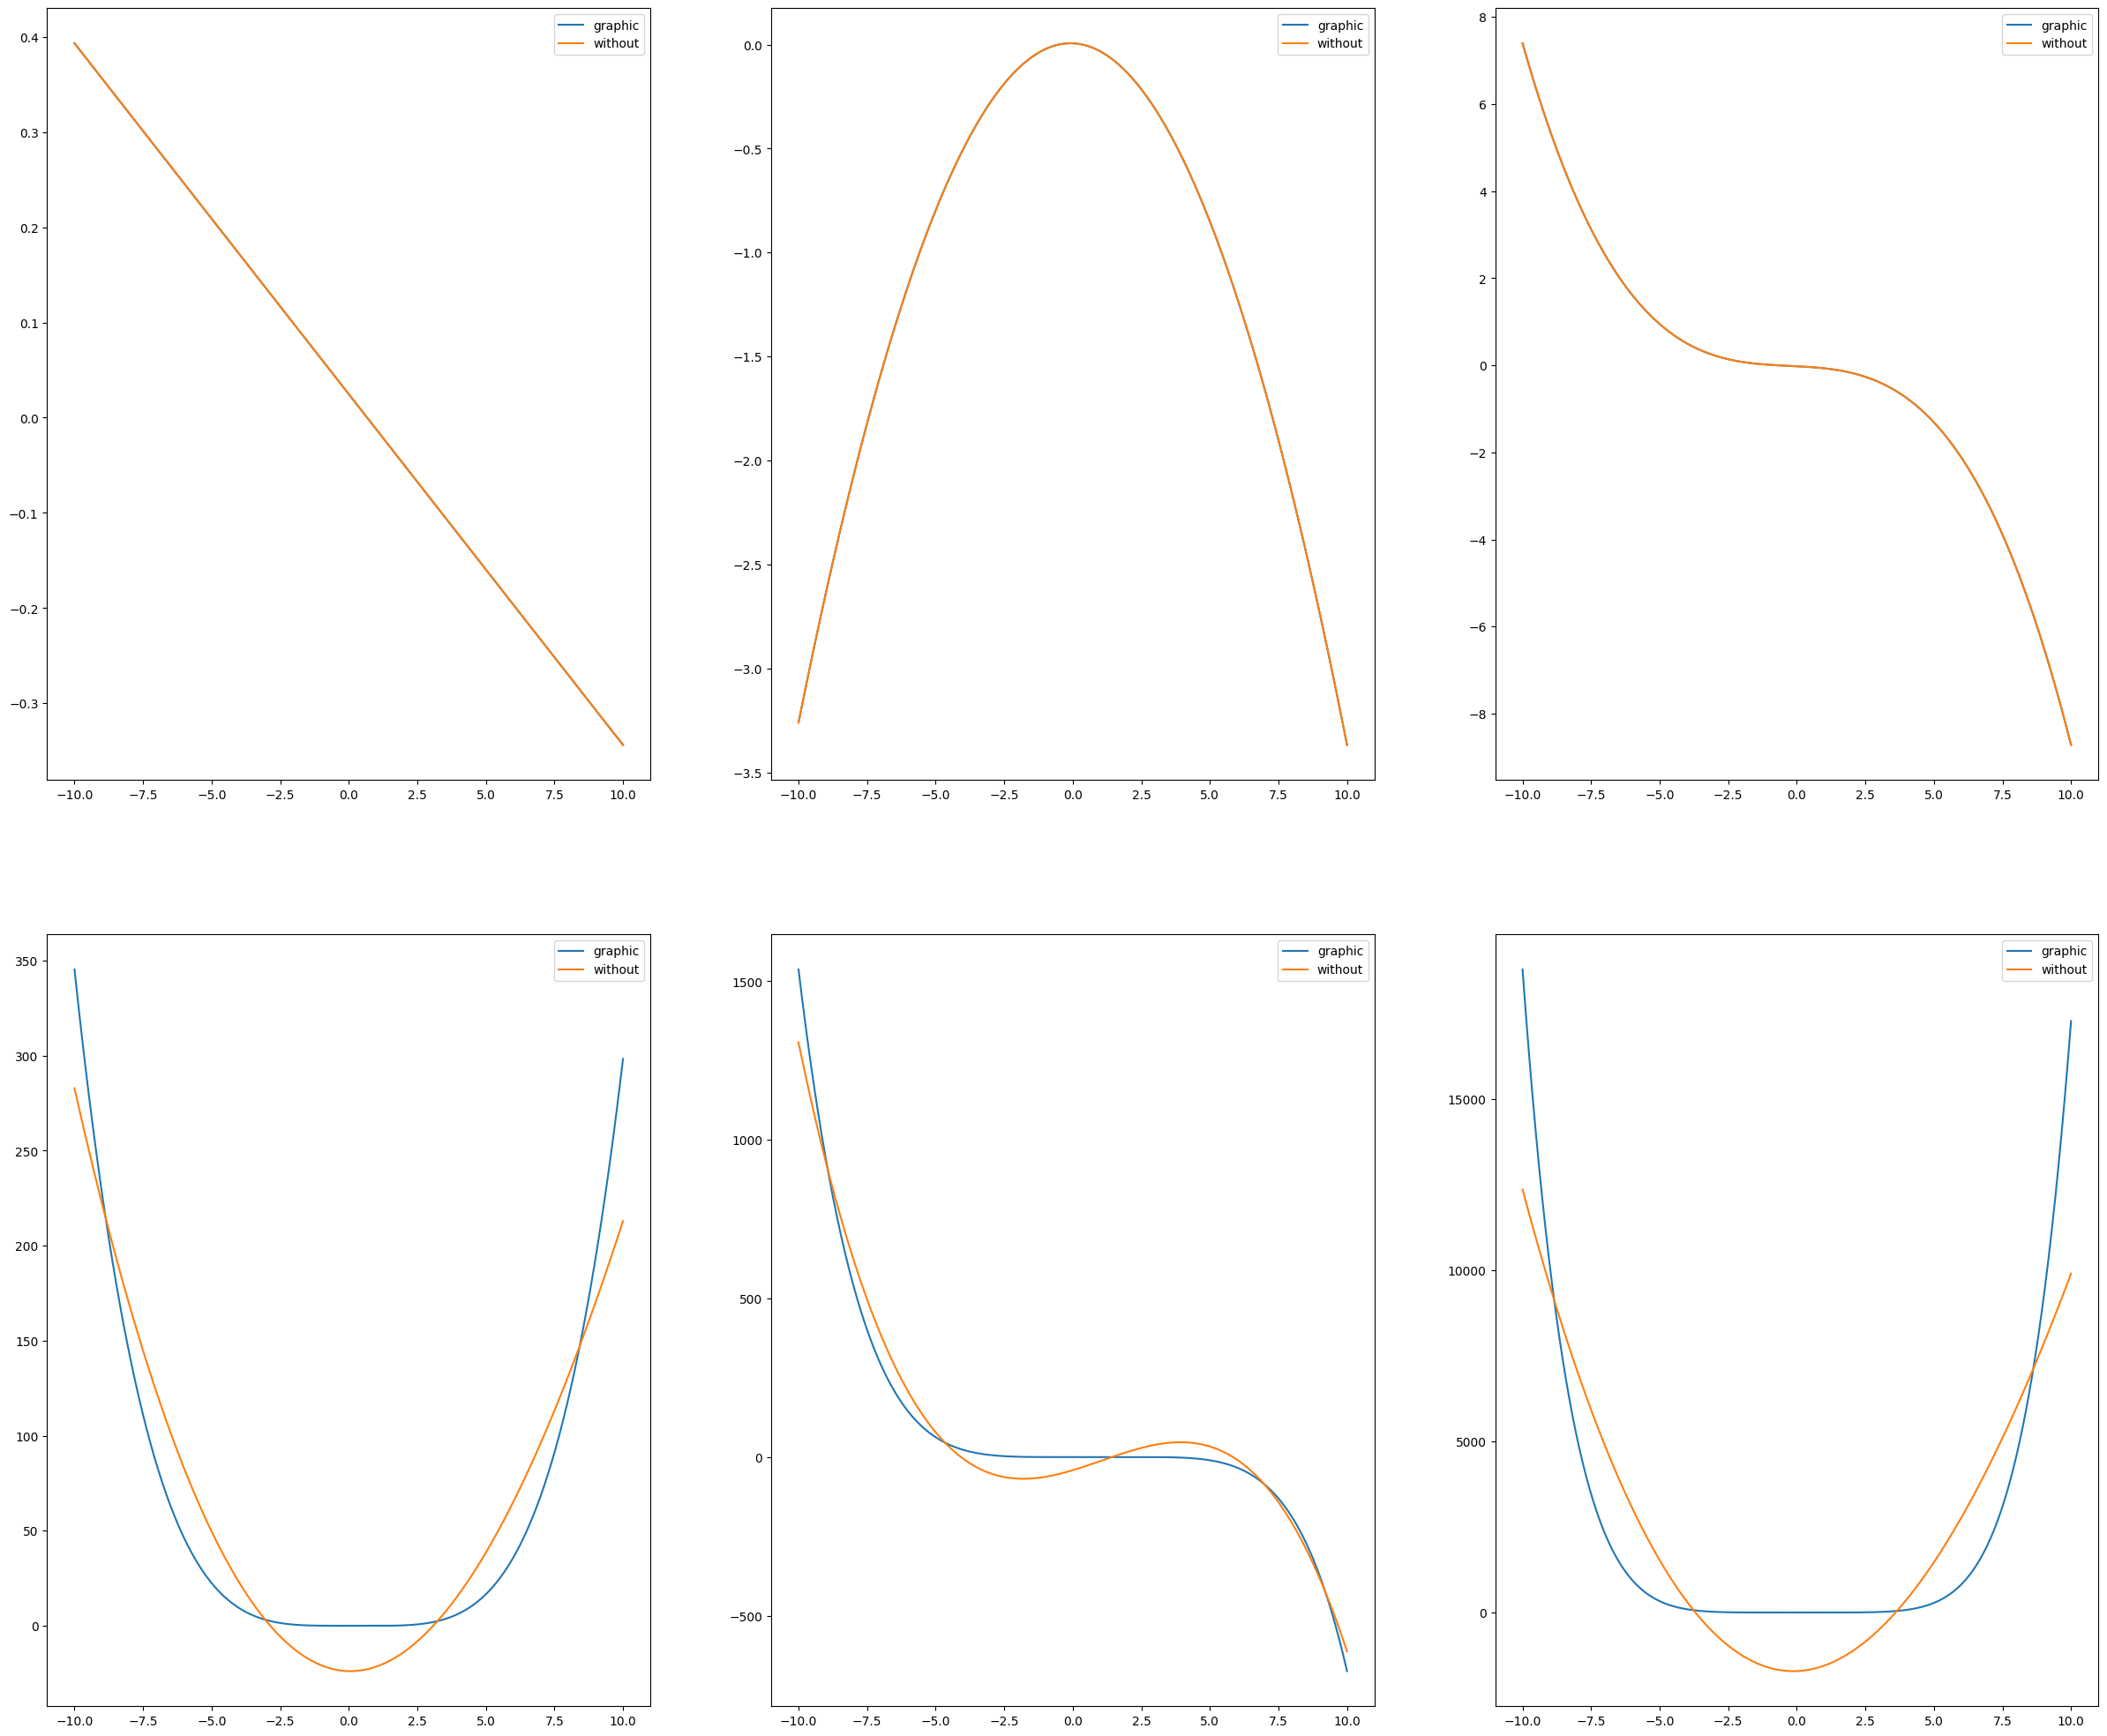

In [101]:
test_polynoms()

На кривых степень которых меньше чем 4, график совпадает полностью. А другие функции приблизились не точно, но достаточно хорошо. Они просто не могут приблизиться точно, так как степень многочлена больше и на больших числах большие степени растут быстрее.

# Регуляризация
Для того чтобы модель не переобучалась, мы хотим ограничить коэффициенты. Рассмотрим 3 способа регуляризации
1. L1 (lasso regularization) <br/>Добавим к Loss: $\lambda \sum_{i=0}^{n-1} |w_i|$
2. L2 (Ridge regularization)<br/>Добавим к Loss: $\lambda \sum_{i=0}^{n-1} w_i^2$
3. Elastic regularization<br/> Это L1 + L2. Итого добавим: $\lambda_1 \sum_{i=0}^{n-1} |w_i|+\lambda_2 \sum_{i=0}^{n-1} w_i^2$


In [102]:
class L1Regularization:
    def __init__(self, llambda):
        self.llambda = llambda

    def __call__(self, b, w):
        return self.llambda * np.sign(b), self.llambda * np.sign(w)


class L2Regularization:
    def __init__(self, llambda):
        self.llambda = llambda

    def __call__(self, b, w):
        return 2 * self.llambda * b, 2 * self.llambda * w


class ElasticRegularization:
    def __init__(self, llambda1, llambda2):
        self.llambda1 = llambda1
        self.llambda2 = llambda2

    def __call__(self, b, w):
        return self.llambda1 * np.sign(b) + 2 * self.llambda2 * b, self.llambda1 * np.sign(w) + 2 * self.llambda2 * w

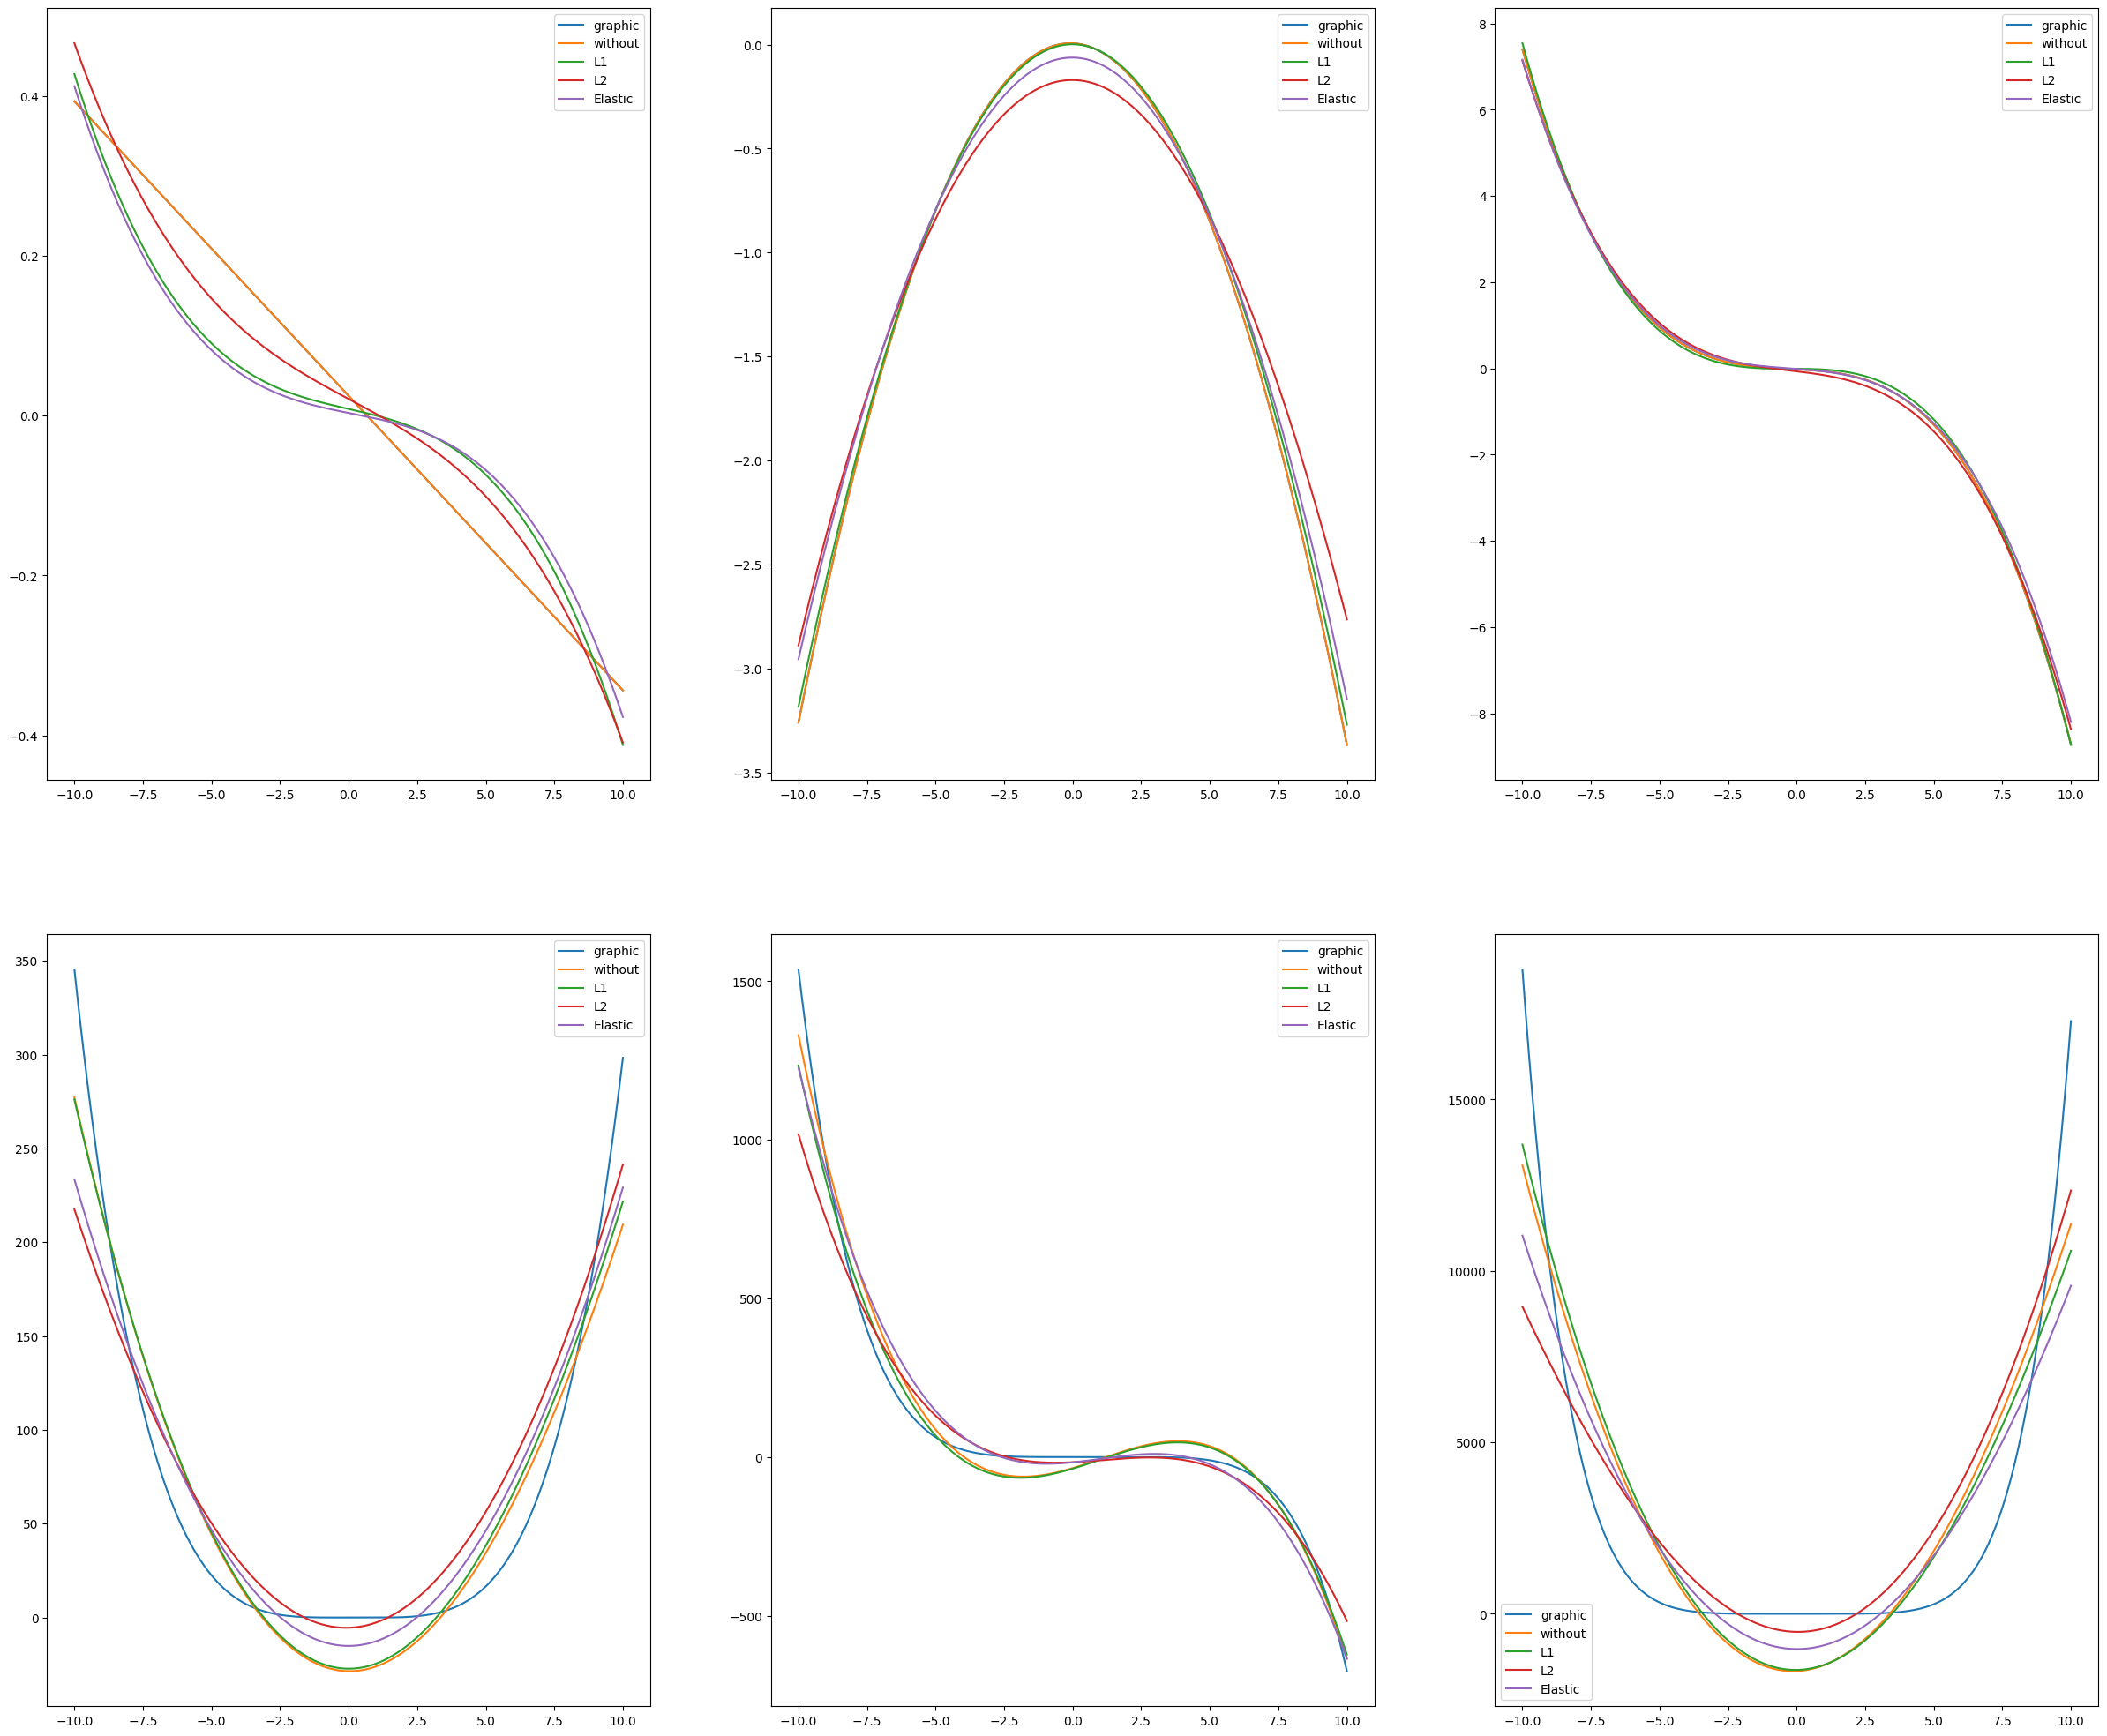

In [103]:
test_polynoms([L1Regularization(0.05), L2Regularization(0.1), ElasticRegularization(0.05, 0.05)],
              ['L1', 'L2', 'Elastic'])

# Вывод
Регуляризация на полиномах со степенью не больше 3 только ухудшили результат. А при степенях больших 3, графики с регуляризацией и без почти идентичны. Скорее всего, тут тоже самое, что с Adam, эффект регуляризации можно заметить в более сложных задачах.